<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px"> 
# Spark MLlib Lesson
---

## Learning Objectives

- Understand how features and labels have to be encoded in spark
- Construct a model pipeline
- Fit regression and classification models with spark

<h1>Lesson Guide<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-1">Learning Objectives</a></span></li><li><span><a href="#Creating-the-spark-context" data-toc-modified-id="Creating-the-spark-context-2">Creating the spark context</a></span></li><li><span><a href="#Regression-example" data-toc-modified-id="Regression-example-3">Regression example</a></span><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3.1">Load the data</a></span></li><li><span><a href="#Put-the-data-into-a-spark-dataframe" data-toc-modified-id="Put-the-data-into-a-spark-dataframe-3.2">Put the data into a spark dataframe</a></span></li><li><span><a href="#Create-feature-columns" data-toc-modified-id="Create-feature-columns-3.3">Create feature columns</a></span></li><li><span><a href="#Rescale-the-data" data-toc-modified-id="Rescale-the-data-3.4">Rescale the data</a></span></li><li><span><a href="#Fit-and-evaluate-a-linear-regression-model" data-toc-modified-id="Fit-and-evaluate-a-linear-regression-model-3.5">Fit and evaluate a linear regression model</a></span></li><li><span><a href="#Linear-regression-with-train-test-split-and-pipeline" data-toc-modified-id="Linear-regression-with-train-test-split-and-pipeline-3.6">Linear regression with train-test split and pipeline</a></span></li><li><span><a href="#Linear-regression-with-grid-search" data-toc-modified-id="Linear-regression-with-grid-search-3.7">Linear regression with grid search</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-4">Classification</a></span><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-4.1">Load the data</a></span></li><li><span><a href="#Create-the-spark-dataframe" data-toc-modified-id="Create-the-spark-dataframe-4.2">Create the spark dataframe</a></span></li><li><span><a href="#Create-feature-columns" data-toc-modified-id="Create-feature-columns-4.3">Create feature columns</a></span></li><li><span><a href="#Rescale-the-data" data-toc-modified-id="Rescale-the-data-4.4">Rescale the data</a></span></li><li><span><a href="#Fit-logistic-regression" data-toc-modified-id="Fit-logistic-regression-4.5">Fit logistic regression</a></span></li><li><span><a href="#Logistic-regression-with-grid-search" data-toc-modified-id="Logistic-regression-with-grid-search-4.6">Logistic regression with grid search</a></span></li><li><span><a href="#Decision-Tree-with-grid-search" data-toc-modified-id="Decision-Tree-with-grid-search-4.7">Decision Tree with grid search</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Creating the spark context

In [2]:
import pyspark as ps    # for the pyspark suite
import warnings         # for displaying warning
from pyspark.sql import SQLContext

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StandardScaler

In [3]:
try:
    # we try to create a SparkContext to work locally on all cpus available
    sc = ps.SparkContext('local[4]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    # give a warning if SparkContext already exists (for use inside pyspark)
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


## Regression example

### Load the data

In [4]:
from sklearn.datasets import load_boston

data  = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MEDV'] = data.target
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [5]:
# 和之前get dataset的方式相同

### Put the data into a spark dataframe

In [6]:
spark_df = sqlContext.createDataFrame(df)

In [7]:
# 用feature cols创建一个spark的dataframe

In [8]:
spark_df.first()

Row(CRIM=0.00632, ZN=18.0, INDUS=2.31, CHAS=0.0, NOX=0.538, RM=6.575, AGE=65.2, DIS=4.09, RAD=1.0, TAX=296.0, PTRATIO=15.3, B=396.9, LSTAT=4.98, MEDV=24.0)

### Create feature columns

In [9]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

In [10]:
vectorAssembler = VectorAssembler(inputCols=data.feature_names,
                                  outputCol="features")

vector_df = vectorAssembler.transform(spark_df)
vector_df.persist()

DataFrame[CRIM: double, ZN: double, INDUS: double, CHAS: double, NOX: double, RM: double, AGE: double, DIS: double, RAD: double, TAX: double, PTRATIO: double, B: double, LSTAT: double, MEDV: double, features: vector]

In [57]:
# RDD 可以使用 persist() 方法或 cache() 方法进行持久化。
#数据将会在第一次 action 操作时进行计算，并缓存在节点的内存中。

In [58]:
vectorAssembler
# VectorAssembler是一个transformer，将多列数据转化为单列的向量列。

VectorAssembler_c0634aa622c3

In [56]:
vector_df

DataFrame[mean radius: double, mean texture: double, mean perimeter: double, mean area: double, mean smoothness: double, mean compactness: double, mean concavity: double, mean concave points: double, mean symmetry: double, mean fractal dimension: double, radius error: double, texture error: double, perimeter error: double, area error: double, smoothness error: double, compactness error: double, concavity error: double, concave points error: double, symmetry error: double, fractal dimension error: double, worst radius: double, worst texture: double, worst perimeter: double, worst area: double, worst smoothness: double, worst compactness: double, worst concavity: double, worst concave points: double, worst symmetry: double, worst fractal dimension: double, label: bigint, features: vector]

In [11]:
vector_df.first()

Row(CRIM=0.00632, ZN=18.0, INDUS=2.31, CHAS=0.0, NOX=0.538, RM=6.575, AGE=65.2, DIS=4.09, RAD=1.0, TAX=296.0, PTRATIO=15.3, B=396.9, LSTAT=4.98, MEDV=24.0, features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]))

In [12]:
vector_df.select('features').show(2)

+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
+--------------------+
only showing top 2 rows



### Rescale the data

In [13]:
scaler = StandardScaler(withMean=True, 
                        inputCol="features", 
                        outputCol="scaledfeatures")
scalerModel = scaler.fit(vector_df)
scaled_df = scalerModel.transform(vector_df)

scaled_df.first()

Row(CRIM=0.00632, ZN=18.0, INDUS=2.31, CHAS=0.0, NOX=0.538, RM=6.575, AGE=65.2, DIS=4.09, RAD=1.0, TAX=296.0, PTRATIO=15.3, B=396.9, LSTAT=4.98, MEDV=24.0, features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]), scaledfeatures=DenseVector([-0.4194, 0.2845, -1.2866, -0.2723, -0.1441, 0.4133, -0.1199, 0.1401, -0.9819, -0.6659, -1.4576, 0.4406, -1.0745]))

### Fit and evaluate a linear regression model

In [14]:
from pyspark.ml.regression import LinearRegression

In [15]:
model = LinearRegression(featuresCol=scaler.getOutputCol(), #为什么两次scaler
                         labelCol='MEDV',
                         maxIter=3000, 
                         regParam=3.0,              #该改边这两个参数选择rige和lassomodel
                         elasticNetParam=0.0)

# Fit the model
model_fit = model.fit(scaled_df)

# Print the coefficients and intercept for linear regression
print("Coefficients: {}".format(model_fit.coefficients))
print("Intercept: {}".format(model_fit.intercept))

# Summarize the model over the training set and print out some metrics
summary_train = model_fit.summary
summary_train.residuals.show()
print("RMSE: {}".format(summary_train.rootMeanSquaredError))
print("r2: {}" .format(summary_train.r2))

Coefficients: [-0.6062632627237937,0.5062345333551295,-0.45076347419998414,0.7222839154612091,-0.7197652622902537,2.655883036940676,-0.20223035959396854,-1.3041718596876453,0.42032700597617795,-0.5159561186446088,-1.5340017317179775,0.7302749733697339,-2.6704591109791393]
Intercept: 22.532806324110666
+-------------------+
|          residuals|
+-------------------+
|-5.7151798743489906|
| -3.501561127864761|
| 4.7042766529601785|
|  4.396390100783677|
|  7.571708144725903|
|  2.788887122370493|
|-0.7843526158647549|
|  5.770899773545327|
| 1.4435189491054565|
|-2.1532747901694904|
| -6.344698272018949|
| -3.937514368581951|
|-0.5178168301829764|
|-0.6189233518252912|
|-2.4800906847445034|
|-0.7630810593572335|
| 1.2531615320005507|
|  -1.32024601031749|
|  2.457384759577973|
|-1.3049574271814386|
+-------------------+
only showing top 20 rows

RMSE: 4.984106058207139
r2: 0.7057398269957282


### Linear regression with train-test split and pipeline

In [16]:
(data_train, data_test) = vector_df.randomSplit([0.7, 0.3],seed=1)

In [17]:
# Add the stages to the Pipeline
pipeline = Pipeline(stages=[scaler, model])

In [18]:
model_fit = pipeline.fit(data_train) #与sklearn的pipeline有一定的区别

In [19]:
# Print the coefficients and intercept for linear regression
print("Coefficients: {}".format(model_fit.stages[1].coefficients))
print("Intercept: {}".format(model_fit.stages[1].intercept))

# Summarize the model over the training set and print out some metrics
summary_train = model_fit.stages[1].summary
summary_train.residuals.show()
print("RMSE: {}".format(summary_train.rootMeanSquaredError))
print("r2: {}".format(summary_train.r2))

Coefficients: [-0.5943224384820947,0.4998150414555451,-0.2950980694178555,0.6562384914943213,-0.8804672381738277,2.832438031819587,-0.28178956066023614,-1.354099680732903,0.3103849086810188,-0.5011005487663269,-1.6260098600146418,0.7782000335039344,-2.469459764855009]
Intercept: 22.547058823529408
+--------------------+
|           residuals|
+--------------------+
|  -5.652697390338769|
|   4.679806484281581|
|0.020008090338365037|
| 0.10006386770952247|
|  -1.735820038103622|
|   4.638616291710413|
|   -3.54645857458695|
|  1.3479123237890676|
|  -1.645521569022847|
|   4.566318077574305|
|  2.8894638840916187|
| -1.7696893559052427|
|  -5.621181746984135|
| -0.8720752283085282|
| 0.16705888219081544|
|  -4.262070333630366|
|  -5.700318853843413|
| -2.4659469448237985|
|  -3.909421286391307|
|  -1.148282163208254|
+--------------------+
only showing top 20 rows

RMSE: 4.9538448168180205
r2: 0.7122273921852267


In [20]:
data_test.select('MEDV','features').take(5)

[Row(MEDV=33.0, features=DenseVector([0.0195, 17.5, 1.38, 0.0, 0.4161, 7.104, 59.5, 9.2229, 3.0, 216.0, 18.6, 393.24, 8.05])),
 Row(MEDV=28.7, features=DenseVector([0.0298, 0.0, 2.18, 0.0, 0.458, 6.43, 58.7, 6.0622, 3.0, 222.0, 18.7, 394.12, 5.21])),
 Row(MEDV=22.0, features=DenseVector([0.0393, 0.0, 3.41, 0.0, 0.489, 6.405, 73.9, 3.0921, 2.0, 270.0, 17.8, 393.55, 8.2])),
 Row(MEDV=22.9, features=DenseVector([0.042, 28.0, 15.04, 0.0, 0.464, 6.442, 53.6, 3.6659, 4.0, 270.0, 18.2, 395.01, 8.16])),
 Row(MEDV=20.5, features=DenseVector([0.0434, 21.0, 5.64, 0.0, 0.439, 6.115, 63.0, 6.8147, 4.0, 243.0, 16.8, 393.97, 9.43]))]

In [21]:
predictions = model_fit.transform(data_test)

In [22]:
# Select example rows to display.
predictions.select("MEDV", "prediction",  "scaledfeatures",'features').show(5)

+----+------------------+--------------------+--------------------+
|MEDV|        prediction|      scaledfeatures|            features|
+----+------------------+--------------------+--------------------+
|33.0|26.078118830897928|[-0.4345522980957...|[0.01951,17.5,1.3...|
|28.7|   25.671655566721|[-0.4332489475014...|[0.02985,0.0,2.18...|
|22.0|26.601071327303938|[-0.4320552598681...|[0.03932,0.0,3.41...|
|22.9| 26.64253197416729|[-0.4317136660470...|[0.04203,28.0,15....|
|20.5|24.290626061321454|[-0.4315447598771...|[0.04337,21.0,5.6...|
+----+------------------+--------------------+--------------------+
only showing top 5 rows



In [23]:
from pyspark.ml.evaluation import RegressionEvaluator

In [24]:
evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='MEDV',
                                metricName='r2')
evaluator.evaluate(predictions)

0.6871192657191219

### Linear regression with grid search

In [25]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [26]:
[parameter.name for parameter in model._defaultParamMap]  #在sklearn中我们有model.get_param()
# elasti 和 regpaprm是最好tune的

['aggregationDepth',
 'solver',
 'standardization',
 'fitIntercept',
 'elasticNetParam',
 'predictionCol',
 'labelCol',
 'featuresCol',
 'maxIter',
 'regParam',
 'tol',
 'loss',
 'epsilon']

In [27]:
scaler = StandardScaler(withMean=True,
                        inputCol="features", 
                        outputCol="scaledfeatures")
model = LinearRegression(featuresCol=scaler.getOutputCol(),
                         labelCol='MEDV',
                         maxIter=3000, 
                         regParam=0.0, 
                         elasticNetParam=0.0)
pipeline = Pipeline(stages=[scaler, model])

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='MEDV',
                                metricName='r2')

paramGrid = ParamGridBuilder() \
    .addGrid(model.regParam, np.logspace(-4,4,9)) \
    .addGrid(model.fitIntercept,[True,False]) \
    .build()

# the actual gridsearch
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

# Run cross-validation, and choose the best set of parameters.
model_fit = crossval.fit(data_train)

In [28]:
java_model = model_fit.bestModel.stages[1]._java_obj

print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid[0]})
print()
print(java_model.explainParams())

{'regParam': 1.0, 'fitIntercept': True}

aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0, current: 0.0)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. (default: 1.35)
featuresCol: features column name (default: features, current: scaledfeatures)
fitIntercept: whether to fit an intercept term (default: true, current: true)
labelCol: label column name (default: label, current: MEDV)
loss: The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError) (default: squaredError)
maxIter: maximum number of iterations (>= 0) (default: 100, current: 3000)
predictionCol: prediction column name (default: prediction)
regParam: regularization parameter (>= 0) (default: 0.0, current: 1.0)
solver: The solver algorithm for optimization. Supported option

In [29]:
prediction = model_fit.transform(data_test)
selected = prediction.select("MEDV", "prediction").limit(5)
selected.take(5)

[Row(MEDV=33.0, prediction=24.632298214506946),
 Row(MEDV=28.7, prediction=25.193275571174663),
 Row(MEDV=22.0, prediction=27.04915281561136),
 Row(MEDV=22.9, prediction=27.75254150308512),
 Row(MEDV=20.5, prediction=23.804896188530293)]

## Classification

### Load the data

In [30]:
from sklearn.datasets import load_breast_cancer

data  = load_breast_cancer()
df = pd.DataFrame(data.data,columns=data.feature_names)
df['label'] = data.target
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'label'],
      dtype='object')

### Create the spark dataframe

In [31]:
spark_df = sqlContext.createDataFrame(df)

spark_df.first()

Row(mean radius=17.99, mean texture=10.38, mean perimeter=122.8, mean area=1001.0, mean smoothness=0.1184, mean compactness=0.2776, mean concavity=0.3001, mean concave points=0.1471, mean symmetry=0.2419, mean fractal dimension=0.07871, radius error=1.095, texture error=0.9053, perimeter error=8.589, area error=153.4, smoothness error=0.006399, compactness error=0.04904, concavity error=0.05373, concave points error=0.01587, symmetry error=0.03003, fractal dimension error=0.006193, worst radius=25.38, worst texture=17.33, worst perimeter=184.6, worst area=2019.0, worst smoothness=0.1622, worst compactness=0.6656, worst concavity=0.7119, worst concave points=0.2654, worst symmetry=0.4601, worst fractal dimension=0.1189, label=0)

### Create feature columns

In [32]:
vectorAssembler = VectorAssembler(inputCols=data.feature_names,
                                  outputCol="features")

vector_df = vectorAssembler.transform(spark_df)
vector_df.persist()
vector_df.select('features').show(2)

+--------------------+
|            features|
+--------------------+
|[17.99,10.38,122....|
|[20.57,17.77,132....|
+--------------------+
only showing top 2 rows



### Rescale the data

In [33]:
scaler = StandardScaler(withMean=True,
                        inputCol="features", 
                        outputCol="scaledfeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(vector_df)

# rescale each feature to range [min, max].
scaled_df = scalerModel.transform(vector_df)

scaled_df.first()

Row(mean radius=17.99, mean texture=10.38, mean perimeter=122.8, mean area=1001.0, mean smoothness=0.1184, mean compactness=0.2776, mean concavity=0.3001, mean concave points=0.1471, mean symmetry=0.2419, mean fractal dimension=0.07871, radius error=1.095, texture error=0.9053, perimeter error=8.589, area error=153.4, smoothness error=0.006399, compactness error=0.04904, concavity error=0.05373, concave points error=0.01587, symmetry error=0.03003, fractal dimension error=0.006193, worst radius=25.38, worst texture=17.33, worst perimeter=184.6, worst area=2019.0, worst smoothness=0.1622, worst compactness=0.6656, worst concavity=0.7119, worst concave points=0.2654, worst symmetry=0.4601, worst fractal dimension=0.1189, label=0, features=DenseVector([17.99, 10.38, 122.8, 1001.0, 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.0787, 1.095, 0.9053, 8.589, 153.4, 0.0064, 0.049, 0.0537, 0.0159, 0.03, 0.0062, 25.38, 17.33, 184.6, 2019.0, 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189]), scaledfeat

### Fit logistic regression

In [34]:
from pyspark.ml.classification import LogisticRegression

In [35]:
model = LogisticRegression(featuresCol='scaledfeatures',labelCol='label')

# Fit the model
model_fit = model.fit(scaled_df)

# Print the coefficients and intercept for linear regression
print("Coefficients: {}".format(model_fit.coefficients))
print("Intercept: {}".format(model_fit.intercept))

# Summarize the model over the training set and print out some metrics
summary_train = model_fit.summary

summary_train.predictions.select('label','probability','prediction').take(5)

Coefficients: [20.023759369515986,-0.8445032297969988,13.431565102304967,-4.793737744616733,-6.851653880977891,24.440434456501624,-22.94500588742294,-9.04040228887829,4.100610362962232,-1.809955810765811,-11.155933940172055,4.8535275595682945,12.332714259968668,-21.59295582702189,-0.8295129878218922,-9.958242220959898,15.562709259191353,-18.291352522212073,4.392854230108701,20.714837186305953,-11.853477560560187,-8.749642878232597,-12.784314141256516,-24.386304841880975,3.375300687834007,2.741311194237784,-6.108756662730771,3.150915492754802,-7.979100906351996,-13.627701306521605]
Intercept: -6.205880857243134


[Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0)]

In [36]:
summary_train.pr.show(2)

+-----------------+---------+
|           recall|precision|
+-----------------+---------+
|              0.0|      1.0|
|0.453781512605042|      1.0|
+-----------------+---------+
only showing top 2 rows



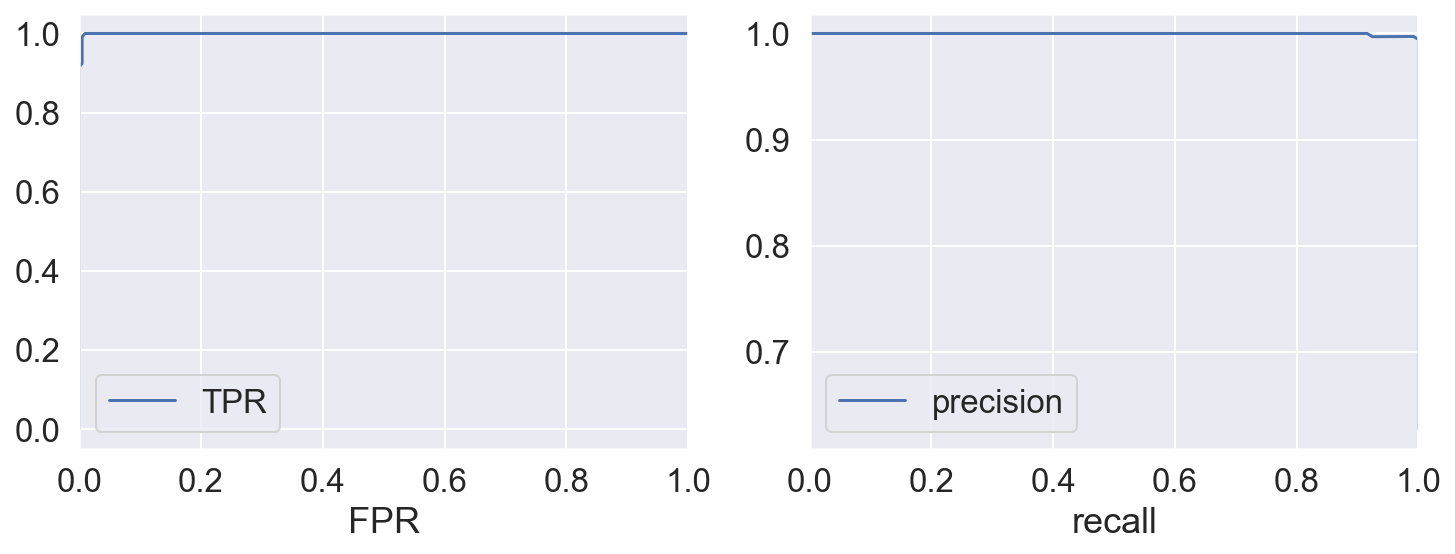

In [37]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
summary_train.roc.toPandas().plot(x='FPR',y='TPR',ax=ax[0])
summary_train.pr.toPandas().plot(x='recall',y='precision',ax=ax[1]);

In [38]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
summary_train.roc.show(5)

+---+-------------------+
|FPR|                TPR|
+---+-------------------+
|0.0|                0.0|
|0.0|  0.453781512605042|
|0.0|0.47058823529411764|
|0.0|0.49019607843137253|
|0.0| 0.5014005602240896|
+---+-------------------+
only showing top 5 rows



In [39]:
print("areaUnderROC: " + str(summary_train.areaUnderROC))

areaUnderROC: 0.999603615030918


In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [41]:
predictions = summary_train.predictions.select('label','prediction')

In [42]:
# possible metric choices: (areaUnderROC|areaUnderPR)'
# 不记得sklearn里面有这个。。。
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol='prediction',
    labelCol='label',
    metricName='areaUnderROC'
        )

evaluator.evaluate(predictions)

0.9938824586438348

In [43]:
predictions.rdd.map(lambda x: (x[0]==x[1])*1).reduce(lambda x,y: x+y)/predictions.count() #在spark里计算predicton的方式

0.9947275922671354

In [44]:
# possible metric choices: (f1|weightedPrecision|weightedRecall|accuracy)'

evaluator = MulticlassClassificationEvaluator(
                    predictionCol='prediction',
                    labelCol='label',
                    metricName='accuracy'
                         )

evaluator.evaluate(predictions)

0.9947275922671354

### Logistic regression with grid search

In [45]:
[parameter.name for parameter in model._defaultParamMap]

['aggregationDepth',
 'standardization',
 'fitIntercept',
 'elasticNetParam',
 'rawPredictionCol',
 'probabilityCol',
 'predictionCol',
 'labelCol',
 'featuresCol',
 'maxIter',
 'regParam',
 'tol',
 'threshold',
 'family']

In [48]:
(data_train, data_test) = vector_df.randomSplit([0.7, 0.3],seed=1)
scaler = StandardScaler(withMean=True,
                        inputCol="features", 
                        outputCol="scaledfeatures")
model = LogisticRegression(featuresCol=scaler.getOutputCol(),
                           labelCol='label')

pipeline = Pipeline(stages=[scaler, model])

evaluator = MulticlassClassificationEvaluator(
                    predictionCol='prediction',
                    labelCol='label',
                    metricName='accuracy'
                         )

paramGrid = ParamGridBuilder() \
    .addGrid(model.regParam, np.logspace(-4,4,9)) \
    .addGrid(model.fitIntercept,[True,False]) \
    .build()

# the actual gridsearch
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

# Run cross-validation, and choose the best set of parameters.
model_fit = crossval.fit(data_train)

print('Average cv scores:')
print(np.around(np.array(model_fit.avgMetrics),4))

java_model = model_fit.bestModel.stages[1]._java_obj

print('Best model parameters:')
print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid[0]})
print()
#print(java_model.explainParams())

predictions = model_fit.transform(data_test)

print('Best model test accuracy:')
print(evaluator.evaluate(predictions))  #以下18个结果就是gridsearch18次尝试的结果显示

Average cv scores:
[0.9486 0.9455 0.9644 0.9692 0.9734 0.9763 0.9602 0.9631 0.9222 0.9452
 0.7237 0.9294 0.6202 0.927  0.6202 0.924  0.6202 0.924 ]
Best model parameters:
{'regParam': 0.01, 'fitIntercept': False}

Best model test accuracy:
0.9881656804733728


### Decision Tree with grid search

In [49]:
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel

In [50]:
model = DecisionTreeClassifier(featuresCol=scaler.getOutputCol(),
                           labelCol='label')

In [51]:
[parameter.name for parameter in model._defaultParamMap]

['seed',
 'rawPredictionCol',
 'probabilityCol',
 'predictionCol',
 'labelCol',
 'featuresCol',
 'maxDepth',
 'maxBins',
 'minInstancesPerNode',
 'minInfoGain',
 'maxMemoryInMB',
 'cacheNodeIds',
 'checkpointInterval',
 'impurity']

In [52]:
(data_train, data_test) = vector_df.randomSplit([0.7, 0.3],seed=1)
scaler = StandardScaler(withMean=True,
                        inputCol="features", 
                        outputCol="scaledfeatures")


pipeline = Pipeline(stages=[scaler, model])

evaluator = MulticlassClassificationEvaluator(
                    predictionCol='prediction',
                    labelCol='label',
                    metricName='accuracy'
                         )

paramGrid = ParamGridBuilder() \
    .addGrid(model.maxDepth, [3, 4, 5]) \
    .build()

# the actual gridsearch
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

# Run cross-validation, and choose the best set of parameters.
model_fit = crossval.fit(data_train)

print('Average cv scores:')
print(np.around(np.array(model_fit.avgMetrics),4))

java_model = model_fit.bestModel.stages[1]._java_obj

print('Best model parameters:')
print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid[0]})
print()
#print(java_model.explainParams())

predictions = model_fit.transform(data_test)

print('Best model test accuracy:')
print(evaluator.evaluate(predictions))

Average cv scores:
[0.913  0.9156 0.9133]
Best model parameters:
{'maxDepth': 4}

Best model test accuracy:
0.9704142011834319


In [53]:
m_1 = DecisionTreeClassificationModel(java_model=java_model)

In [54]:
m_1.featureImportances

SparseVector(30, {7: 0.0581, 10: 0.0107, 15: 0.0356, 21: 0.0913, 22: 0.7007, 27: 0.1036})